# 3D DEEP LEARNING WITH POINTNET

In this notebook you can find how to
* Process a 3D Point Cloud Dataset
* Visualize the Dataset in 3D
* Build a 3D Deep Learning Model
* Test on new data

The code has been adapted from Intel's version for myself: https://github.com/intel-isl/Open3D-PointNet

## Imports
* Open3D: A Point Cloud Library; we'll use it for Visualization
* PyTorch: A Deep Learning Library
* All the other usual libraries (numpy, matplotlib, random, ...)

In [ ]:
# Do this if you don't have Open3D
!pip install open3d==0.11.2
!pip install progressbar

In [1]:
# Usual Imports
from __future__ import print_function
import os
import random
from random import randrange
from IPython.display import clear_output
from PIL import Image
import os.path
import errno
import json
import codecs
import numpy as np
import progressbar
import sys
import matplotlib.pyplot as plt

# Open3D Imports
import open3d as o3
print(o3.__version__)
from open3d import JVisualizer # Useful for Jupyter Notebook Visualization

# PyTorch Imports
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import torch.nn.functional as F
if torch.cuda.is_available():
    import torch.backends.cudnn as cudnn

0.11.2
2.0.1


# Dataset

We are going to work with the ShapeNet Dataset.<p>
It's coming from Standford and will allow us to do both Classification and Segmentation.<p>
Here's an X-Wing from the DataSet:
![XWING](https://www.shapenet.org/shapenet/screenshots/models/3dw/d/d/9/e/c/e07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356/dd9ece07d4bc696c2bafe808edd44356-5.png)

## Download the Dataset

In [ ]:
#Run this only if you don't already have the Dataset
!wget -nv https://shapenet.cs.stanford.edu/ericyi/shapenetcore_partanno_segmentation_benchmark_v0.zip --no-check-certificate
!unzip shapenetcore_partanno_segmentation_benchmark_v0.zip
!rm shapenetcore_partanno_segmentation_benchmark_v0.zip

## Preprocess the Dataset

In [2]:
# General parameters
NUM_POINTS = 10000
DATA_FOLDER = 'shapenetcore_partanno_segmentation_benchmark_v0'

In [3]:
class PartDataset(torch.utils.data.Dataset):
    """
    This preprocesses the dataset.
    """
    def __init__(self, root, npoints = 2500, classification = False, class_choice = None, train = True, image=False):
        '''
        Assign the parameters: number of points, root folder, category file, image, classification.
        '''
        self.npoints = npoints
        self.root = root
        self.catfile = os.path.join(self.root, 'synsetoffset2category.txt')
        self.cat = {}
        self.image = image
        self.classification = classification
        '''
        Open the Category File and Map Folders to Categories
        '''
        with open(self.catfile, 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = ls[1]
        
        '''
        Select categories from the dataset. 
        ex: Call in parameters "class_choice=["Airplane"].
        '''
        if not class_choice is  None:
            self.cat = {k:v for k,v in self.cat.items() if k in class_choice}
        
        '''
        For every item in a specific category, assign the point, segmentation, and image.
        Basically, read the dataset and store the labels.
        '''
        self.meta = {}        
        for item in self.cat:
            #print('category', item)
            self.meta[item] = []
            dir_point = os.path.join(self.root, self.cat[item], 'points')
            dir_seg = os.path.join(self.root, self.cat[item], 'points_label')
            dir_seg_img = os.path.join(self.root, self.cat[item],'seg_img') 
            
            fns = sorted(os.listdir(dir_point))
            if train:
                fns = fns[:int(len(fns) * 0.9)]
            else:
                fns = fns[int(len(fns) * 0.9):]

            for fn in fns: # FOR EVERY POINT CLOUD FILE
                token = (os.path.splitext(os.path.basename(fn))[0])
                self.meta[item].append((os.path.join(dir_point, token + '.pts'), os.path.join(dir_seg, token + '.seg'), os.path.join(dir_seg_img, token+'.png')))

        '''
        Create a Variable where you have (item, points, segmentation points, segmentation image)
        '''
        self.datapath = []
        for item in self.cat:
            for fn in self.meta[item]:
                self.datapath.append((item, fn[0], fn[1],fn[2]))

        self.classes = dict(zip(sorted(self.cat), range(len(self.cat))))
        
        self.num_seg_classes = 0
        if not self.classification: # Take the Segmentation Labels
            for i in range(len(self.datapath)//50):
                l = len(np.unique(np.loadtxt(self.datapath[i][-2]).astype(np.uint8)))
                if l > self.num_seg_classes:
                    self.num_seg_classes = l
        #print(self.num_seg_classes)

    def __getitem__(self, index):
        '''
        This will be used to pick a specific element from the dataset.
        self.datapath is the dataset.
        Each element is under format "class, points, segmentation labels, segmentation image"
        '''
        # Get one Element
        fn = self.datapath[index]
        
        # get its Class
        cls = self.classes[fn[0]]
        
        # Read the Point Cloud
        point_set = np.asarray(o3.io.read_point_cloud(fn[1], format='xyz').points,dtype=np.float32)
        
        # Read the Segmentation Data
        seg = np.loadtxt(fn[2]).astype(np.int64)

        
        image = Image.open(fn[3])

        choice = np.random.choice(len(seg), self.npoints, replace=True)
        
        #resample
        point_set = point_set[choice, :]        
        seg = seg[choice]
        point_set = torch.from_numpy(point_set)
        seg = torch.from_numpy(seg)
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        
        if self.classification:
            if self.image:
                return point_set, cls, image
            else:
                return point_set, cls

        else:
            if self.image:
                return point_set, seg, image
            else:
                return point_set, seg

    def __len__(self):
        return len(self.datapath)

In [4]:
# Problem ontology
classes_dict = {'Airplane': 0, 'Bag': 1, 'Cap': 2, 'Car': 3, 'Chair': 4, 
                'Earphone': 5, 'Guitar': 6, 'Knife': 7, 'Lamp': 8, 'Laptop': 9,
                'Motorbike': 10, 'Mug': 11, 'Pistol': 12, 'Rocket': 13, 
                'Skateboard': 14, 'Table': 15}

## Visualize the Dataset with Open3D

In [5]:
# Simple point cloud coloring mapping
def read_pointnet_colors(seg_labels):
    map_label_to_rgb = {
        1: [0, 255, 0],
        2: [0, 0, 255],
        3: [255, 0, 0],
        4: [255, 0, 255],  # purple
        5: [0, 255, 255],  # cyan
        6: [255, 255, 0],  # yellow
    }
    colors = np.array([map_label_to_rgb[label] for label in seg_labels])
    return colors

Number of objects 15990
----------
Point Cloud Caracteristics:
torch.Size([2500, 3]) torch.FloatTensor torch.Size([2500]) torch.LongTensor
----------
Point Cloud
tensor([[ 0.0884, -0.0853, -0.1028],
        [-0.0121, -0.0458, -0.1319],
        [-0.0292, -0.0505,  0.0501],
        ...,
        [-0.1278, -0.0659, -0.0095],
        [-0.0349, -0.0418,  0.1593],
        [ 0.0253, -0.0454, -0.0313]])
----------
Label on Part Segmentation
tensor([4, 2, 2,  ..., 1, 2, 1])
----------
Label on Classification
Airplane


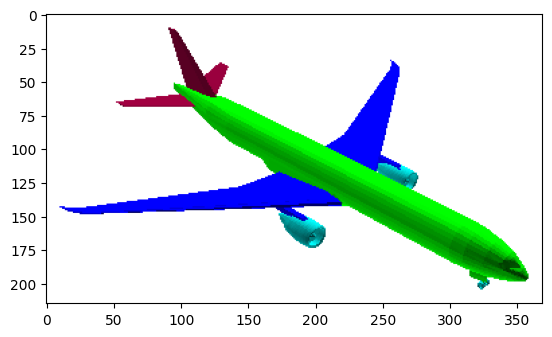

In [6]:
# Load the ShapeNet Dataset
# Default parameters for PartDataset: npoints = 2500, classification = False, class_choice = None, train = True, image=False

d = PartDataset(root=DATA_FOLDER,image=True)
print("Number of objects",len(d))
print('----------')

idx = random.randint(0,len(d))
ps, seg, img = d[idx]

print("Point Cloud Caracteristics:")
print(ps.size(), ps.type(), seg.size(),seg.type())
print('----------')
print("Point Cloud")
print(ps)
print('----------')
print("Label on Part Segmentation")
print(seg)
print('----------')

d = PartDataset(root=DATA_FOLDER,classification=True,image=False)
ps2, cls= d[idx]

print("Label on Classification")
classes_dict_list = list(classes_dict)
print(classes_dict_list[cls.item()])

plt.imshow(np.asarray(img))

In [7]:
test_vis = JVisualizer()
test_vis.clear()
clear_output()
test_cloud = o3.geometry.PointCloud()
test_cloud.points = o3.utility.Vector3dVector(ps)
test_cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

test_vis.add_geometry(test_cloud)
test_vis.show()

JVisualizer with 1 geometries

# 3D Deep Learning Model: PointNet

## Build the Model: PointNet

**The model is PointNet.**<p>
![PointNet](https://d3i71xaburhd42.cloudfront.net/c3b6a072288e134f5ae6afe3eebc970ffb65cb68/3-Figure2-1.png)

It's coming from the paper: https://arxiv.org/pdf/1612.00593.pdf

### Build the T-Net

In this part, you need to re-implement the image you see above!<p>
Watch solution if you're stuck!

In [8]:
class STN3d(nn.Module):
    """
    T-Net Model. 
    STN stands for Spatial Transformer Network.
    """
    def __init__(self, num_points = 2500):
        super(STN3d, self).__init__()
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.pool=nn.MaxPool1d(num_points)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,9)
        self.relu = nn.ReLU()
        ##
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        bs = x.size()[0]
        xb= self.relu(self.bn1(self.conv1(x)))
        xb= self.relu(self.bn2(self.conv2(xb)))
        xb= self.relu(self.bn3(self.conv3(xb)))
        pool = self.pool(xb)
        flat = nn.Flatten(1)(pool)
        xb=self.relu(self.bn4(self.fc1(flat)))
        xb=self.relu(self.bn5(self.fc2(xb)))
        xb=self.fc3(xb)
        init = torch.eye(1, requires_grad=True).repeat(bs,9)
        if xb.is_cuda:
            init=init.cuda()
        # add identity to the output
        x = xb+ init
        x = x.view(-1,3,3) 
        return x
sim_data = Variable(torch.rand(32,3,2500))
trans = STN3d()
out = trans(sim_data)
print("Output Size must be [32, 3, 3]")
print('stn', out.size())


Output Size must be [32, 3, 3]
stn torch.Size([32, 3, 3])


### Build the Feature T-Net + MLP

In [9]:
class PointNetfeat(nn.Module):
    """
    This is the T-Net for Feature Transform.
    There is also MLP part 64,128,1024.
    """
    def __init__(self, num_points = 2500, global_feat = True):
        super(PointNetfeat, self).__init__()
        self.stn=STN3d(num_points=num_points)
        self.conv1 = nn.Conv1d(3,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.pool=nn.MaxPool1d(num_points)
        ##
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.num_points = num_points
        self.global_feat=global_feat
    
    def forward(self, x):
        bs = x.size()[0]
        input_trans = self.stn(x)
        x = x.transpose(2,1)
        x = torch.bmm(x,input_trans)
        x= x.transpose(2,1)
        x = F.relu(self.bn1(self.conv1(x)))
        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        pool = self.pool(x)
        x = nn.Flatten(1)(pool)
        if self.global_feat:
            return x, input_trans
        else:
            x_expand=torch.unsqueeze(x,-1)
            x = x_expand.expand(-1,-1,self.num_points)
            #x = x.view(-1, 1024, 1).repeat(1, 1, self.num_points)
            return torch.cat([x,pointfeat],1), trans

In [10]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

global feat torch.Size([32, 1024])


### Build the Classification Head

In [11]:
class PointNetCls(nn.Module):
    """
    Network for Classification: 512, 256, K.
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetCls, self).__init__()
        self.feat=PointNetfeat(num_points,global_feat=True)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k)
        ##
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        x,input_trans=self.feat(x)
        x=F.relu(self.bn1(self.fc1(x)))
        x=F.relu(self.bn2(self.fc2(x)))
        x=self.fc3(x)
        return F.log_softmax(x,dim=-1), input_trans

In [12]:
pointfeat = PointNetfeat(global_feat=True)
out, _ = pointfeat(sim_data)
print('global feat', out.size())

pointfeat = PointNetfeat(global_feat=False)
out, _ = pointfeat(sim_data)
print('point feat', out.size())

cls = PointNetCls(k = 5)
out, _ = cls(sim_data)
print('class', out.size())

global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])


### Build the Segmentation Head

In [13]:
class PointNetDenseCls(nn.Module):
    """
    Network for Segmentation
    """
    def __init__(self, num_points = 2500, k = 2):
        super(PointNetDenseCls, self).__init__()
        self.num_points = num_points
        self.k = k
        self.feat = PointNetfeat(num_points, global_feat=False)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
        batchsize = x.size()[0]
        x, trans = self.feat(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.conv4(x)
        x = x.transpose(2,1).contiguous()
        x = F.log_softmax(x.view(-1,self.k), dim=-1)
        x = x.view(batchsize, self.num_points, self.k)
        return x, trans

In [14]:
seg = PointNetDenseCls(k = 3)
print(seg)
out, _ = seg(sim_data)
print('seg', out.size())

PointNetDenseCls(
  (feat): PointNetfeat(
    (stn): STN3d(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (pool): MaxPool1d(kernel_size=2500, stride=2500, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (relu): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=Tru

## Train the Model for classification and segmentation

In [15]:
#Define Hyperparameters
batchSize = 32  
num_points = 2500
workers =4
n_epoch = 3
output_folder="cls" #Out folder, saving each epoch

In [19]:
# DATASET & DATA LOADER

# Train Dataset & DataLoader
dataset = PartDataset(root=DATA_FOLDER,npoints=num_points,classification=True,train=True)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batchSize,shuffle=True,num_workers=workers)

# Test Dataset & DataLoader
test_dataset = PartDataset(root=DATA_FOLDER,npoints=num_points,classification=True,train=False)
testdataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batchSize,shuffle=False,num_workers=workers)

blue = lambda x:'\033[94m' + x + '\033[0m'

# CALL THE MODEL
num_classes = len(classes_dict.items())

classifier = PointNetCls(k=num_classes,num_points=num_points)

optimizer = optim.SGD(classifier.parameters(), lr=0.01,momentum=0.9)
if torch.cuda.is_available():
    classifier.cuda()

num_batch = len(dataset)//batchSize # What is the number of batch?

# TRAIN ON EPOCHS
for epoch in range(n_epoch):
    for i, data in enumerate(dataloader, 0):
        """
        Get Points & Classification Label
        """
        points,target =  data
        points = points.transpose(2,1)
        if torch.cuda.is_available():
            points, target = points.cuda(), target.cuda()
        
        optimizer.zero_grad()
        classifier = classifier.train()
        pred, _ = classifier(points)
        loss = F.nll_loss(pred,target[:,0])
        loss.backward()
        optimizer.step()

        pred_choice = pred.data.max(1)[1]
        correct = pred_choice.eq(target.data).cpu().sum()
        print('[%d: %d/%d] train loss: %f accuracy: %f' %(epoch, i, num_batch, loss.item(),correct.item() / float(batchSize)))

        if i % 10 == 0:
            j, data = next(enumerate(testdataloader, 0))
            points, target = data
            points, target = Variable(points), Variable(target[:,0])
            points = points.transpose(2,1)
            if torch.cuda.is_available():
                points, target = points.cuda(), target.cuda()
            classifier = classifier.eval()
            pred, _ = classifier(points)
            loss = F.nll_loss(pred, target)
            pred_choice = pred.data.max(1)[1]
            correct = pred_choice.eq(target.data).cpu().sum()
            print('[%d: %d/%d] %s loss: %f accuracy: %f' %(epoch, i, num_batch, blue('test'), loss.item(), correct.item()/float(batchSize)))

    torch.save(classifier.state_dict(), '%s/cls_model_%d.pth' % (output_folder, epoch))

[0: 0/499] train loss: 2.673019 accuracy: 3.000000
[0: 0/499] test loss: 2.716008 accuracy: 1.000000
[0: 1/499] train loss: 2.524560 accuracy: 3.125000
[0: 2/499] train loss: 2.111665 accuracy: 5.156250
[0: 3/499] train loss: 1.692018 accuracy: 6.937500
[0: 4/499] train loss: 1.189825 accuracy: 6.812500
[0: 5/499] train loss: 1.199373 accuracy: 6.250000
[0: 6/499] train loss: 1.066493 accuracy: 7.093750
[0: 7/499] train loss: 0.676755 accuracy: 8.625000
[0: 8/499] train loss: 0.827089 accuracy: 6.375000
[0: 9/499] train loss: 1.010515 accuracy: 6.218750
[0: 10/499] train loss: 1.146791 accuracy: 5.718750
[0: 10/499] test loss: 0.288562 accuracy: 1.000000
[0: 11/499] train loss: 0.268027 accuracy: 7.812500
[0: 12/499] train loss: 0.499625 accuracy: 7.218750
[0: 13/499] train loss: 0.465694 accuracy: 6.656250
[0: 14/499] train loss: 0.642924 accuracy: 6.187500
[0: 15/499] train loss: 0.899828 accuracy: 5.937500
[0: 16/499] train loss: 0.837457 accuracy: 6.656250
[0: 17/499] train loss: 1

Exception ignored in: <function _releaseLock at 0x7ff18da11af0>
Traceback (most recent call last):
  File "/home/nj644/anaconda3/envs/pcl/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


[0: 160/499] test loss: 0.002656 accuracy: 1.000000
[0: 161/499] train loss: 0.081868 accuracy: 6.000000
[0: 162/499] train loss: 0.109726 accuracy: 5.937500
[0: 163/499] train loss: 0.208152 accuracy: 6.562500
[0: 164/499] train loss: 0.223242 accuracy: 5.937500
[0: 165/499] train loss: 0.883686 accuracy: 5.531250
[0: 166/499] train loss: 0.146505 accuracy: 5.500000
[0: 167/499] train loss: 0.403144 accuracy: 5.906250
[0: 168/499] train loss: 0.081217 accuracy: 7.562500
[0: 169/499] train loss: 0.019336 accuracy: 6.750000
[0: 170/499] train loss: 0.107295 accuracy: 5.562500
[0: 170/499] test loss: 0.007415 accuracy: 1.000000
[0: 171/499] train loss: 0.132751 accuracy: 7.437500
[0: 172/499] train loss: 0.118897 accuracy: 5.812500
[0: 173/499] train loss: 0.372737 accuracy: 6.187500
[0: 174/499] train loss: 0.237755 accuracy: 7.375000
[0: 175/499] train loss: 0.265429 accuracy: 5.375000
[0: 176/499] train loss: 0.107582 accuracy: 5.187500
[0: 177/499] train loss: 0.199699 accuracy: 5.65

[0: 273/499] train loss: 0.119680 accuracy: 6.375000
[0: 274/499] train loss: 0.162137 accuracy: 6.031250
[0: 275/499] train loss: 0.528962 accuracy: 5.750000
[0: 276/499] train loss: 0.063419 accuracy: 7.250000
[0: 277/499] train loss: 0.288726 accuracy: 5.875000
[0: 278/499] train loss: 0.197382 accuracy: 6.750000
[0: 279/499] train loss: 0.011961 accuracy: 6.187500
[0: 280/499] train loss: 0.036474 accuracy: 7.500000


In [ ]:
NUM_POINTS = 5000
MODEL_PATH = 'cls/cls_model_2.pth'

classifier = PointNetCls(k=num_classes,num_points=NUM_POINTS)

if torch.cuda.is_available():
    classifier.cuda()
    classifier.load_state_dict(torch.load(MODEL_PATH))
else:
    classifier.load_state_dict(torch.load(MODEL_PATH, map_location='cpu'))
classifier.eval()

# Visualize the output

In [ ]:
# Three.js based visualizer
visualizer = JVisualizer()

test_dataset_seg = PartDataset(root=DATA_FOLDER, train=False, classification=False, npoints=NUM_POINTS)#Get a dataset for testing

# Basic inference and visualization loop
MAX_SAMPLES = 15

for samples in range(MAX_SAMPLES):
    random_index = randrange(len(test_dataset_seg))
    print('[Sample {} / {}]'.format(random_index, len(test_dataset_seg)))
    
    # clean visualization
    visualizer.clear()
    clear_output()

    # get next sample
    point_set, seg = test_dataset_seg.__getitem__(random_index)

    # create cloud for visualization
    cloud = o3.geometry.PointCloud()
    cloud.points = o3.utility.Vector3dVector(point_set)
    cloud.colors = o3.utility.Vector3dVector(read_pointnet_colors(seg.numpy()))

    # perform inference in GPU
    points = Variable(point_set.unsqueeze(0))
    points = points.transpose(2, 1)
    if torch.cuda.is_available():
        points = points.cuda()
    pred_logsoft, _ = classifier(points)

    # move data back to cpu for visualization
    pred_logsoft_cpu = pred_logsoft.data.cpu().numpy().squeeze()
    pred_soft_cpu = np.exp(pred_logsoft_cpu)
    pred_class = np.argmax(pred_soft_cpu)

    # let's visualize the input sample
    visualizer.add_geometry(cloud)
    visualizer.show()
    
    # Visualize probabilities
    plt.xticks(list(classes_dict.values()), list(classes_dict.keys()),rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Probabilities')
    plt.plot(list(classes_dict.values()), pred_soft_cpu)
    plt.show()

    input('Your object is a [{}] with probability {:0.3}. Press enter to continue!'
          .format(list(classes_dict.keys())[pred_class], pred_soft_cpu[pred_class]))